In [1]:
import pandas as pd
from extract_data import extract_data
import numpy as np
import umap
import sklearn
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from purity_check import purity_check

In [2]:
from purity_check import purity_check

In [3]:
df = pd.read_csv('data_q2.csv')

In [4]:
for i in df.columns:
    if 'generalelection' in i:
        df = df.drop(i,1)

In [5]:
data_array = np.array(df)
data_array = np.delete(data_array,-1,1)
data_array = np.delete(data_array,0,1)

In [6]:
general = extract_data("data","data",1)

In [7]:
df['partyId'] = general['partyId']

In [8]:
data = df
#removing don't know's and no votes from the labels, label choice is who people voted in the general election
data['partyId'] = data['partyId'].fillna("Don't know") 

list_to_remove = []
for i in range(data.shape[0]):
    if data.loc[i,'partyId'] == "Don't know":
        list_to_remove.append(i)
    elif data.loc[i,'partyId'] == "No - none":
        list_to_remove.append(i)
    elif data.loc[i,'partyId'] == "Plaid Cymru":
        list_to_remove.append(i)
    elif data.loc[i,'partyId'] == "Scottish National Party (SNP)":
        list_to_remove.append(i)
    elif data.loc[i,'partyId'] ==    'I would/did not vote':
        list_to_remove.append(i)
    elif data.loc[i,'partyId'] ==  'Other':
        list_to_remove.append(i)
        
        
    
data = data.drop(list_to_remove,0)
data = data.reset_index(drop=True)


In [9]:
labels = pd.DataFrame({'partyId':data['partyId']})
labels['Party'] = labels['partyId'].cat.remove_unused_categories()

In [10]:
mapping = {item:i for i, item in enumerate(labels["Party"].unique())}
labels["EnumLabl"] = labels["Party"].apply(lambda x: mapping[x])

In [11]:

labels_array = np.array(labels['EnumLabl'],dtype=np.float64)

In [12]:
data_array = np.delete(data_array,list_to_remove,0)


In [13]:
%%time
embedding = umap.UMAP(n_neighbors=15,n_components=3).fit_transform(data_array,y=labels_array)

Wall time: 22.5 s


Text(0.5, 1.0, 'Full Data set Embedded via UMAP using Labels')

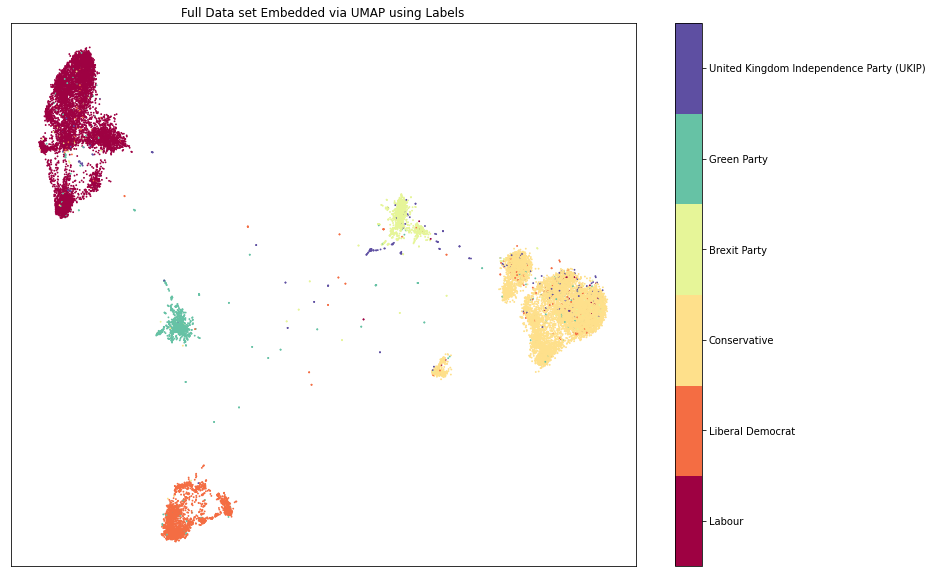

In [14]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(embedding[:,0],embedding[:,1], s=0.7, c=labels_array, cmap='Spectral', alpha=1.0,)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(labels["Party"].unique())
plt.title('Full Data set Embedded via UMAP using Labels')

In [15]:
def f1_cluster_assignments_lists(optimal_cluster_assignments,stage=None):
    optimal_cluster_assignments_names = []
    optimal_cluster_assignments_number = []
    for i in range(optimal_cluster_assignments[0].shape[0]):
        name = data.loc[optimal_cluster_assignments[0][i],'partyId']
        cluster_number = optimal_cluster_assignments[1][i]
        
        if stage != None:
            print(name)
            name = name + "_stage_" + str(stage)
        optimal_cluster_assignments_names.append(name)
        optimal_cluster_assignments_number.append(cluster_number)
    return optimal_cluster_assignments_names, optimal_cluster_assignments_number

In [16]:
def kmeans_distance(cluster,data_compare,n_clusters):
    cost_matrix = np.zeros([data_compare.shape[0],n_clusters])
    for i in range(data_compare.shape[0]):
        point_costs = []
        for c in range(n_clusters):
            diss = np.linalg.norm(data_compare[i,:]-cluster[c,:])
            cost_matrix[i,c]=diss
    return cost_matrix

In [17]:
#Elbow method
cluster_numbers = []
sum_of_squared_distances = []
for i in range(6,20):
    cluster_numbers.append(i)
    kmeans = KMeans(i, random_state=0)
    kmeans.fit_predict(embedding)
    sum_of_squared_distances.append(kmeans.inertia_)
   
    

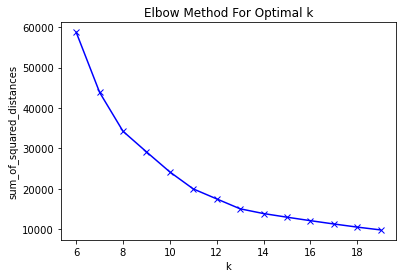

In [18]:
plt.plot(cluster_numbers, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
n_clusters = 11
#from elbow plot

In [20]:
cluster_numbers.append(n_clusters)
kmeans = KMeans(n_clusters, random_state=0)
kmeans.fit_predict(embedding)
kmeans_cost = kmeans_distance(kmeans.cluster_centers_,embedding,n_clusters)
optimal_assignments = linear_sum_assignment(kmeans_cost)
cluster_assignments_names, cluster_assignments_number = f1_cluster_assignments_lists(optimal_assignments)
cluster_assignments = pd.DataFrame({'Party':data['partyId']})
cluster_assignments['FirstAssignment'] = kmeans.labels_
for x in range(len(cluster_assignments_number)):
    cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].replace(int(cluster_assignments_number[x]),cluster_assignments_names[x])
cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].astype('category')
cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].cat.remove_unused_categories()
cluster_assignments['Party'] = cluster_assignments['Party'].cat.remove_unused_categories()
sum_of_squared_distances.append(kmeans.inertia_)
y_true = np.transpose(np.array(cluster_assignments['Party']))
y_pred = np.transpose(np.array(cluster_assignments['FirstAssignment']))
f1 = sklearn.metrics.f1_score(y_pred,y_true,average='micro')
mean_purity = purity_check(kmeans.labels_,labels,n_clusters,vote_or_pref = 'partyId')

print('F1 score is:',f1)
print('purity is:', mean_purity)

F1 score is: 0.9625296783941291
purity is: 0.9600719079236999


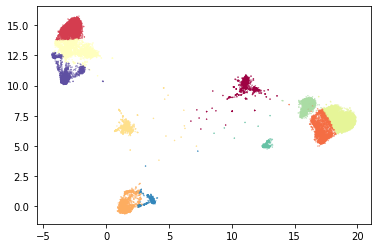

In [22]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans.labels_, s=0.1, cmap='Spectral');

In [25]:
def optimal_cluster_assignments_lists(optimal_cluster_assignments,stage=None):
    optimal_cluster_assignments_names = []
    optimal_cluster_assignments_number = []
    for i in range(optimal_cluster_assignments[0].shape[0]):
        name = data.loc[optimal_cluster_assignments[0][i],'partyId']
        cluster_number = optimal_cluster_assignments[1][i]
        name_count = 0 
        for x in range(len(optimal_cluster_assignments_names)):
                if name in optimal_cluster_assignments_names[x]:
                    name_count += 1
        if name_count != 0:
            name = name + str(name_count+1)
        if stage != None:
            print(name)
            name = name + "_stage_" + str(stage)
        optimal_cluster_assignments_names.append(name)
        optimal_cluster_assignments_number.append(cluster_number)
    return optimal_cluster_assignments_names, optimal_cluster_assignments_number

In [26]:
kmeans_cost = kmeans_distance(kmeans.cluster_centers_,embedding,n_clusters)
first_optimal_assignments = linear_sum_assignment(kmeans_cost)
first_cluster_assignments_names, first_cluster_assignments_number = optimal_cluster_assignments_lists(first_optimal_assignments)

In [27]:
print(first_cluster_assignments_number)
print(first_cluster_assignments_names)

[8, 6, 4, 3, 2, 7, 9, 5, 0, 10, 1]
['Conservative', 'Conservative2', 'Green Party', 'Liberal Democrat', 'Conservative3', 'Conservative4', 'Liberal Democrat2', 'Labour', 'Brexit Party', 'Labour2', 'Labour3']


In [28]:
sklearn.preprocessing.normalize(kmeans_cost)

array([[0.30165993, 0.03567484, 0.43839494, ..., 0.36504515, 0.29293903,
        0.05480282],
       [0.30064861, 0.02445929, 0.43460732, ..., 0.36492257, 0.29931084,
        0.06455531],
       [0.29997383, 0.0458156 , 0.44215127, ..., 0.36323714, 0.28804701,
        0.03814929],
       ...,
       [0.12087529, 0.45414638, 0.07737996, ..., 0.09621552, 0.3326569 ,
        0.44204961],
       [0.13770428, 0.48252616, 0.12550347, ..., 0.00733817, 0.27558567,
        0.45146054],
       [0.1544889 , 0.44956915, 0.03746781, ..., 0.13305188, 0.33475497,
        0.44407323]])